In [11]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd

df = pd.read_csv(r"C:\ise3230\grocery_kroger_priced_2.csv")

items = df["Product_Name"].tolist()

fat = df.set_index("Product_Name")["Fat_g"].to_dict()
sodium = df.set_index("Product_Name")["Sodium_g"].to_dict()
protein = df.set_index("Product_Name")["Protein_g"].to_dict()
calories = df.set_index("Product_Name")["Calories"].to_dict()
cost = df.set_index("Product_Name")["Price"].to_dict()

m = gp.Model("diet_7day")
m.Params.LogToConsole = 0

# Want to create a weekly meal plan over the course of 7 school days
days = range(7)

# x[i, d] = number of servings of food i on day d. We constrain it to be at most 2
x = m.addVars(items, days, vtype=GRB.INTEGER, lb=0, ub=2, name="x")

# y[i, d] = 1 if food i is used at least once on day d
y = m.addVars(items, days, vtype=GRB.BINARY, name="y")

# Objective is to minimize cost of meal plan (we are broke college students)
m.setObjective(gp.quicksum(cost[i] * x[i, d] for i in items for d in days), GRB.MINIMIZE)

FAT_MAX = 190
SODIUM_MAX = 2
PROTEIN_MIN = 150
CALORIE_MIN = 10000
#FIBER_MIN = 75
#SUGAR_MAX = 100
MAX_ITEMS_PER_DAY = 30
MIN_DISTINCT_ITEMS_PER_DAY = 10

for d in days:
    m.addConstr(gp.quicksum(fat[i] * x[i, d] for i in items) <= FAT_MAX, name=f"fat_max_day{d}")
    m.addConstr(gp.quicksum(sodium[i] * x[i, d] for i in items) <= SODIUM_MAX, name=f"sodium_max_day{d}")
    m.addConstr(gp.quicksum(protein[i] * x[i, d] for i in items) >= PROTEIN_MIN, name=f"protein_min_day{d}")
    m.addConstr(gp.quicksum(calories[i] * x[i, d] for i in items) >= CALORIE_MIN, name=f"calorie_min_day{d}")
    #m.addConstr(gp.quicksum(fiber[i] * x[i, d] for i in items) >= FIBER_MIN, name=f"fiber_min_day{d}")
    #m.addConstr(gp.quicksum(sugar[i] * x[i, d] for i in items) <= SUGAR_MAX, name=f"sugar_max_day{d}")

    # Limit total servings of each food per day
    m.addConstr(gp.quicksum(x[i, d] for i in items) <= MAX_ITEMS_PER_DAY, name=f"max_items_day{d}")

    
    # If y[i,d] = 0, then x[i,d] must be 0. And, if x[i,d] >= 1, then y[i,d] = 1
    for i in items:
        # Have x <= 2y so that we make the max servings of an item per day equal to 2
        m.addConstr(x[i, d] <= 2 * y[i, d], name=f"x_le_2y_{i}_day{d}")
        # Make sure that we can't have x equal to 0 if y is equal to 1 (this doesn't make sense given the definitions of x and y)
        m.addConstr(x[i, d] >= y[i, d],   name=f"x_ge_y_{i}_day{d}")

    # Want atleast 10 different items per day for variety constraint
    m.addConstr(gp.quicksum(y[i, d] for i in items) >= MIN_DISTINCT_ITEMS_PER_DAY, name=f"min_distinct_items_day{d}")

# Each food can appear on at most 2 days in the week
# Do this outside of the loop since this is a constraint across the week instead of across a day
for i in items:
    m.addConstr(gp.quicksum(y[i, d] for d in days) <= 2, name=f"max_days_for_{i}")

m.optimize()
print(f"Number of variables: {m.NumVars}")
print(f"Number of constraints: {m.NumConstrs}")
print(f"Number of binary variables: {m.NumBinVars}")
print(f"Number of integer variables: {m.NumIntVars}")
print(f"Solve time: {m.Runtime} seconds")

if m.Status == GRB.OPTIMAL:
    print("Total 7-day cost = $%.2f" % m.ObjVal)
    
    total_calories_week = sum(calories[i] * x[i, d].X for i in items for d in days)
    print(f"Total weekly calories: {total_calories_week:.0f}\n")
    
    for d in days:
        print(f"Day {d + 1}:")
        
        day_calories = 0
        day_cost = 0
        
        for i in items:
            if x[i, d].X > 1e-6:
                servings = int(round(x[i, d].X))
                item_calories = calories[i] * servings
                item_cost = cost[i] * servings
                
                day_calories += item_calories
                day_cost += item_cost
                
                print(f"  {i}: {servings} serving(s) - {item_calories:.0f} cal, ${item_cost:.2f}")
        
        print(f"  Day total: {day_calories:.0f} calories, ${day_cost:.2f}\n")
else:
    print("No optimal solution found. Status:", m.Status)

Set parameter LogToConsole to value 0
Number of variables: 17906
Number of constraints: 19227
Number of binary variables: 8953
Number of integer variables: 17906
Solve time: 331.34699988365173 seconds
Total 7-day cost = $69.72
Total weekly calories: 73427

Day 1:
  Original Instant Oatmeal: 1 serving(s) - 1400 cal, $1.79
  Mixed Beans: 1 serving(s) - 914 cal, $0.89
  Baby Lima Beans: 1 serving(s) - 947 cal, $1.49
  Bean Soup Mix: 1 serving(s) - 947 cal, $1.25
  Shortbread Tartlet Shells: 1 serving(s) - 2310 cal, $1.99
  Bread Crumbs: 1 serving(s) - 1350 cal, $1.49
  Chili Hot Beans: 1 serving(s) - 74 cal, $0.89
  Apple Jelly: 1 serving(s) - 1400 cal, $1.99
  Flavored Stuffing Mix, Cornbread: 1 serving(s) - 393 cal, $1.00
  Barbecue Flavored Potato Chips: 1 serving(s) - 380 cal, $0.50
  Day total: 10115 calories, $13.28

Day 2:
  Chunk Light Tuna in Water: 1 serving(s) - 255 cal, $0.99
  Strawberry Banana: 1 serving(s) - 82 cal, $0.80
  Sardines In Soybean Oil: 1 serving(s) - 367 cal, $

Constraint Analysis by Day

Day 1:
  Fat: 186.1g / 190g (97.9%) - TIGHT
  Sodium: 1.80g / 2g (90.0%)
  Protein: 338.1g / 150g min (225.4%)
  Calories: 10115 / 10000 min (101.2%) - TIGHT
  Distinct items: 10 / 10 min (100%) - TIGHT

Day 2:
  Fat: 72.3g / 190g (38.1%)
  Sodium: 2.00g / 2g (100.0%) - TIGHT
  Protein: 150.5g / 150g min (100.3%) - TIGHT
  Calories: 10010 / 10000 min (100.1%) - TIGHT
  Distinct items: 10 / 10 min (100%) - TIGHT

Day 3:
  Fat: 72.9g / 190g (38.4%)
  Sodium: 1.20g / 2g (60.0%)
  Protein: 151.4g / 150g min (100.9%) - TIGHT
  Calories: 10042 / 10000 min (100.4%) - TIGHT
  Distinct items: 10 / 10 min (100%) - TIGHT

Day 4:
  Fat: 12.6g / 190g (6.6%)
  Sodium: 0.70g / 2g (35.0%)
  Protein: 574.7g / 150g min (383.1%)
  Calories: 11619 / 10000 min (116.2%)
  Distinct items: 10 / 10 min (100%) - TIGHT

Day 5:
  Fat: 74.3g / 190g (39.1%)
  Sodium: 1.90g / 2g (95.0%)
  Protein: 150.0g / 150g min (100.0%) - TIGHT
  Calories: 10035 / 10000 min (100.4%) - TIGHT
  Distinct

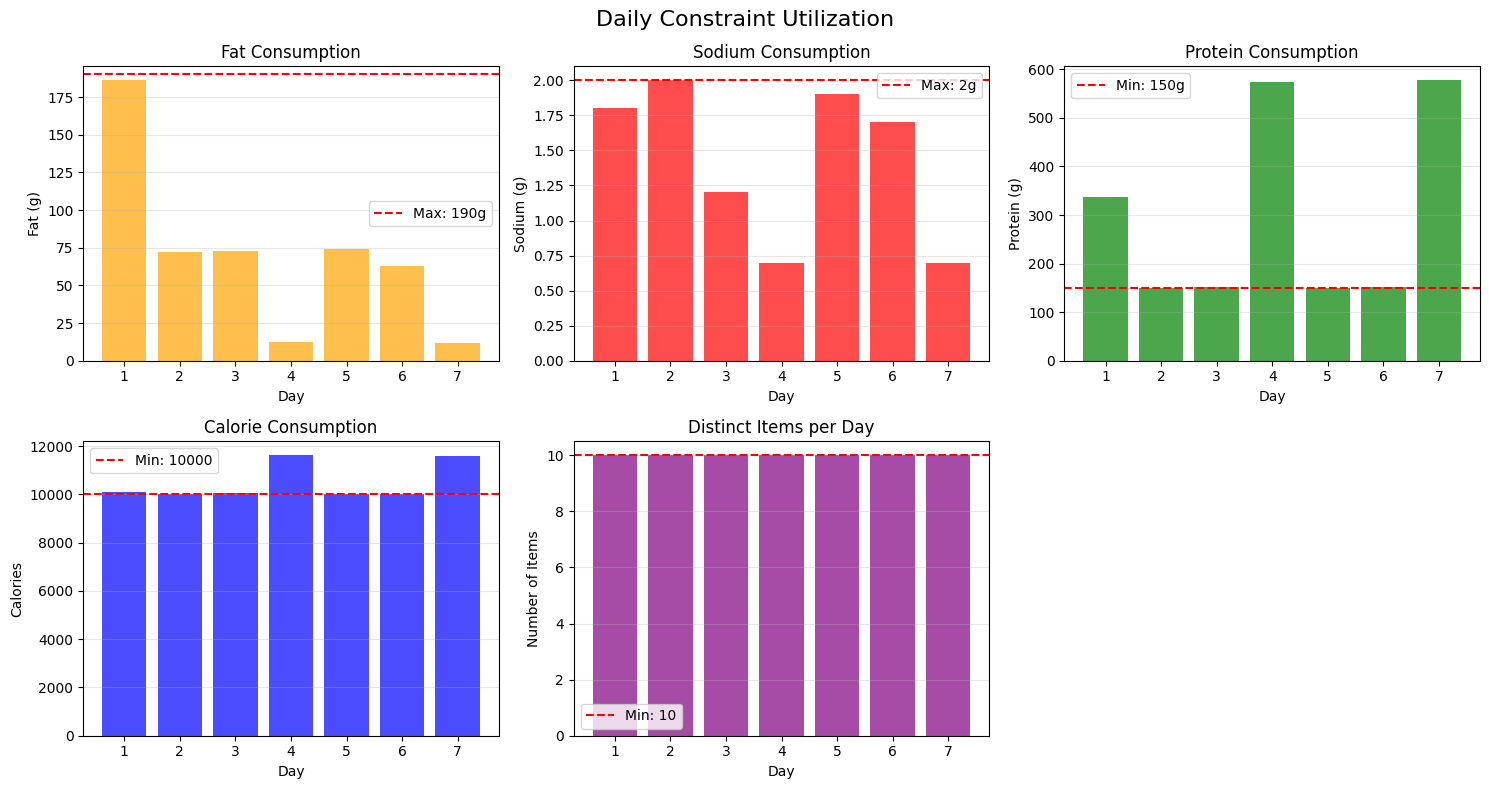


Overall Tight Constraints Summary:
  Day 1: Fat at 97.9%
  Day 1: Calories at 101.2%
  Day 1: Distinct items at 100%
  Day 2: Sodium at 100.0%
  Day 2: Protein at 100.3%
  Day 2: Calories at 100.1%
  Day 2: Distinct items at 100%
  Day 3: Protein at 100.9%
  Day 3: Calories at 100.4%
  Day 3: Distinct items at 100%
  Day 4: Distinct items at 100%
  Day 5: Protein at 100.0%
  Day 5: Calories at 100.4%
  Day 5: Distinct items at 100%
  Day 6: Protein at 100.6%
  Day 6: Calories at 100.3%
  Day 6: Distinct items at 100%
  Day 7: Distinct items at 100%


In [ ]:
# Code for visualizations

import matplotlib.pyplot as plt
import numpy as np

constraint_data = []

for d in days:
    day_fat = sum(fat[i] * x[i, d].X for i in items)
    day_sodium = sum(sodium[i] * x[i, d].X for i in items)
    day_protein = sum(protein[i] * x[i, d].X for i in items)
    day_calories = sum(calories[i] * x[i, d].X for i in items)
    day_items = sum(y[i, d].X for i in items)
    
    constraint_data.append({
        'day': d + 1,
        'fat': day_fat,
        'sodium': day_sodium,
        'protein': day_protein,
        'calories': day_calories,
        'distinct_items': day_items
    })


for data in constraint_data:
    d = data['day']
    print(f"\nDay {d}:")
    
    fat_pct = (data['fat'] / FAT_MAX) * 100
    sodium_pct = (data['sodium'] / SODIUM_MAX) * 100
    protein_pct = (data['protein'] / PROTEIN_MIN) * 100
    calorie_pct = (data['calories'] / CALORIE_MIN) * 100
    items_pct = (data['distinct_items'] / MIN_DISTINCT_ITEMS_PER_DAY) * 100
    
    print(f"  Fat: {data['fat']:.1f}g / {FAT_MAX}g ({fat_pct:.1f}%)" + 
          (" - TIGHT" if fat_pct > 95 else ""))
    print(f"  Sodium: {data['sodium']:.2f}g / {SODIUM_MAX}g ({sodium_pct:.1f}%)" + 
          (" - TIGHT" if sodium_pct > 95 else ""))
    print(f"  Protein: {data['protein']:.1f}g / {PROTEIN_MIN}g min ({protein_pct:.1f}%)" + 
          (" - TIGHT" if protein_pct < 105 else ""))
    print(f"  Calories: {data['calories']:.0f} / {CALORIE_MIN} min ({calorie_pct:.1f}%)" + 
          (" - TIGHT" if calorie_pct < 105 else ""))
    print(f"  Distinct items: {int(data['distinct_items'])} / {MIN_DISTINCT_ITEMS_PER_DAY} min ({items_pct:.0f}%)" + 
          (" - TIGHT" if items_pct < 105 else ""))

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Daily Constraint Utilization', fontsize=16)

days_list = [d['day'] for d in constraint_data]

# Fat constraint (max)
ax = axes[0, 0]
fat_vals = [d['fat'] for d in constraint_data]
ax.bar(days_list, fat_vals, color='orange', alpha=0.7)
ax.axhline(y=FAT_MAX, color='r', linestyle='--', label=f'Max: {FAT_MAX}g')
ax.set_xlabel('Day')
ax.set_ylabel('Fat (g)')
ax.set_title('Fat Consumption')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Sodium constraint (max)
ax = axes[0, 1]
sodium_vals = [d['sodium'] for d in constraint_data]
ax.bar(days_list, sodium_vals, color='red', alpha=0.7)
ax.axhline(y=SODIUM_MAX, color='r', linestyle='--', label=f'Max: {SODIUM_MAX}g')
ax.set_xlabel('Day')
ax.set_ylabel('Sodium (g)')
ax.set_title('Sodium Consumption')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Protein constraint (min)
ax = axes[0, 2]
protein_vals = [d['protein'] for d in constraint_data]
ax.bar(days_list, protein_vals, color='green', alpha=0.7)
ax.axhline(y=PROTEIN_MIN, color='r', linestyle='--', label=f'Min: {PROTEIN_MIN}g')
ax.set_xlabel('Day')
ax.set_ylabel('Protein (g)')
ax.set_title('Protein Consumption')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Calories constraint (min)
ax = axes[1, 0]
calorie_vals = [d['calories'] for d in constraint_data]
ax.bar(days_list, calorie_vals, color='blue', alpha=0.7)
ax.axhline(y=CALORIE_MIN, color='r', linestyle='--', label=f'Min: {CALORIE_MIN}')
ax.set_xlabel('Day')
ax.set_ylabel('Calories')
ax.set_title('Calorie Consumption')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Distinct items constraint (min)
ax = axes[1, 1]
items_vals = [d['distinct_items'] for d in constraint_data]
ax.bar(days_list, items_vals, color='purple', alpha=0.7)
ax.axhline(y=MIN_DISTINCT_ITEMS_PER_DAY, color='r', linestyle='--', label=f'Min: {MIN_DISTINCT_ITEMS_PER_DAY}')
ax.set_xlabel('Day')
ax.set_ylabel('Number of Items')
ax.set_title('Distinct Items per Day')
ax.legend()
ax.grid(axis='y', alpha=0.3)
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("Overall Tight Constraints Summary:")
print("=" * 80)

tight_constraints = []
for d in constraint_data:
    day = d['day']
    if (d['fat'] / FAT_MAX) > 0.95:
        tight_constraints.append(f"Day {day}: Fat at {(d['fat']/FAT_MAX)*100:.1f}%")
    if (d['sodium'] / SODIUM_MAX) > 0.95:
        tight_constraints.append(f"Day {day}: Sodium at {(d['sodium']/SODIUM_MAX)*100:.1f}%")
    if (d['protein'] / PROTEIN_MIN) < 1.05:
        tight_constraints.append(f"Day {day}: Protein at {(d['protein']/PROTEIN_MIN)*100:.1f}%")
    if (d['calories'] / CALORIE_MIN) < 1.05:
        tight_constraints.append(f"Day {day}: Calories at {(d['calories']/CALORIE_MIN)*100:.1f}%")
    if (d['distinct_items'] / MIN_DISTINCT_ITEMS_PER_DAY) < 1.05:
        tight_constraints.append(f"Day {day}: Distinct items at {(d['distinct_items']/MIN_DISTINCT_ITEMS_PER_DAY)*100:.0f}%")

if tight_constraints:
    for constraint in tight_constraints:
        print(f"  {constraint}")
else:
    print("  No tight constraints (all constraints have >5% slack)")